In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [3]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

In [4]:
''' Optimization Functions '''

def sgd(lr, nabla, cache, alpha=0.9):
    cache = [alpha*c - lr*n for n, c in zip(nabla, cache)]
    update = cache.copy()
    return cache, update

In [5]:
''' Learning Rate Schedulers '''

def constant(lr, epoch):
    return lr

def time_decay(lr, epoch, decay_rate):
    return lr / (1. + decay_rate*epoch)

def exp_decay(lr, epoch, decay_rate):
    return lr * np.exp(-epoch*decay_rate)

def step_decay(lr, epoch, decay_rate, decay_step):
    return lr * decay_rate**(np.floor(epoch/decay_step))

In [6]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.report = dict()
        self.report['loss'] = []
        self.report['re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)

    def feedforward(self, x):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a in zip(self.weights, self.biases, self.act_funcs):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def learn(self, cost_func, epochs, dataset,
            optimizer, lr_schedulers,
            eta=0.001, alpha=0.9, batch_size=32, verbos=1):

        for i in tqdm(range(epochs), disable=(not verbos)):
            eta_ = lr_schedulers(eta, i)
            lr = eta_/batch_size

            cache_b = [np.zeros(b.shape) for b in self.biases]
            cache_w = [np.zeros(w.shape) for w in self.weights]
            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(dataset, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                cache_b, update_b = optimizer(lr, nabla_b, cache_b)
                self.biases = [b+nb for b, nb in zip(self.biases, update_b)]
                cache_w, update_w = optimizer(lr, nabla_w, cache_w)
                self.weights = [w+nw for w, nw in zip(self.weights, update_w)]

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['re'].append(np.mean(np.abs((y_h-y_)/y_)))

            if verbos == 1:
                print('loss: ', self.report['loss'][-1],
                      'reletive error: ', self.report['re'][-1])

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['loss'] = []
        self.report['re'] = []

In [7]:
''' Dataset Functions '''

def make_dataset(N):
    dataset = dict()
    dataset['count'] = N
    dataset['X'] = np.random.uniform(-1, 1, (N, 10, 1))
    dataset['y'] = np.sin(np.mean(dataset['X'][:, :5], axis=1)) + \
                    np.cos(np.mean(dataset['X'][:, 5:], axis=1))

    return dataset

  2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

loss:  27.07002938371289 reletive error:  0.8739911368806957


  4%|▍         | 2/50 [00:01<00:39,  1.22it/s]

loss:  0.032160715209400836 reletive error:  0.24982722785670813


  6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

loss:  0.03215344864179416 reletive error:  0.24979479262018872


  8%|▊         | 4/50 [00:03<00:41,  1.12it/s]

loss:  0.03216593483454734 reletive error:  0.24986708020586124


 10%|█         | 5/50 [00:04<00:39,  1.15it/s]

loss:  0.032153385014299055 reletive error:  0.25001435872093053


 12%|█▏        | 6/50 [00:05<00:37,  1.18it/s]

loss:  0.03215407170336398 reletive error:  0.24964751461808787


 14%|█▍        | 7/50 [00:05<00:35,  1.21it/s]

loss:  0.032159596621541935 reletive error:  0.24999772576676774


 16%|█▌        | 8/50 [00:06<00:35,  1.19it/s]

loss:  0.032160878972591025 reletive error:  0.24993497929094416


 18%|█▊        | 9/50 [00:07<00:34,  1.19it/s]

loss:  0.03215268218180724 reletive error:  0.2502818715246142


 20%|██        | 10/50 [00:08<00:34,  1.18it/s]

loss:  0.03215337929069185 reletive error:  0.2498698581306725


 22%|██▏       | 11/50 [00:09<00:33,  1.17it/s]

loss:  0.03216203415638114 reletive error:  0.24984671890386262


 24%|██▍       | 12/50 [00:10<00:32,  1.18it/s]

loss:  0.03216086048552459 reletive error:  0.2498961860270012


 26%|██▌       | 13/50 [00:10<00:31,  1.19it/s]

loss:  0.03214906008253646 reletive error:  0.2500756538466688


 28%|██▊       | 14/50 [00:11<00:29,  1.20it/s]

loss:  0.03215522929384668 reletive error:  0.249525429526917


 30%|███       | 15/50 [00:12<00:29,  1.19it/s]

loss:  0.03215117105539726 reletive error:  0.250024607135577


 32%|███▏      | 16/50 [00:13<00:28,  1.19it/s]

loss:  0.032160303428795535 reletive error:  0.2500684350742817


 34%|███▍      | 17/50 [00:14<00:28,  1.17it/s]

loss:  0.0321460800337712 reletive error:  0.24999658603420474


 36%|███▌      | 18/50 [00:15<00:27,  1.17it/s]

loss:  0.032160005843281214 reletive error:  0.24989699953610803


 38%|███▊      | 19/50 [00:16<00:26,  1.16it/s]

loss:  0.03215242034609322 reletive error:  0.24961444409636466


 40%|████      | 20/50 [00:17<00:26,  1.15it/s]

loss:  0.03215800633355335 reletive error:  0.24993933080930855


 42%|████▏     | 21/50 [00:18<00:25,  1.15it/s]

loss:  0.032160925699626884 reletive error:  0.25014696236283823


 44%|████▍     | 22/50 [00:19<00:25,  1.11it/s]

loss:  0.032166821668338244 reletive error:  0.24989493601861631


 46%|████▌     | 23/50 [00:21<00:25,  1.06it/s]

loss:  0.03215793644087063 reletive error:  0.2500806501053277


 48%|████▊     | 24/50 [00:22<00:24,  1.05it/s]

loss:  0.03215747711411859 reletive error:  0.2499353526814837


 50%|█████     | 25/50 [00:24<00:24,  1.02it/s]

loss:  0.03214963033839534 reletive error:  0.24934802907743642


 52%|█████▏    | 26/50 [00:25<00:23,  1.03it/s]

loss:  0.03215947208312363 reletive error:  0.25035449337487564


 54%|█████▍    | 27/50 [00:25<00:22,  1.04it/s]

loss:  0.03215766246511529 reletive error:  0.2495546071084575


 56%|█████▌    | 28/50 [00:26<00:20,  1.05it/s]

loss:  0.03215706916459437 reletive error:  0.2503929431945625


 58%|█████▊    | 29/50 [00:27<00:19,  1.06it/s]

loss:  0.03215877844894259 reletive error:  0.24997884649486055


 60%|██████    | 30/50 [00:28<00:18,  1.07it/s]

loss:  0.032160168795359094 reletive error:  0.24952746524398722


 62%|██████▏   | 31/50 [00:28<00:17,  1.07it/s]

loss:  0.03215722981371673 reletive error:  0.24995883355957943


 64%|██████▍   | 32/50 [00:29<00:16,  1.08it/s]

loss:  0.032161425379077374 reletive error:  0.24972188127308764


 66%|██████▌   | 33/50 [00:30<00:15,  1.08it/s]

loss:  0.03215280908564477 reletive error:  0.24962088673950747


 68%|██████▊   | 34/50 [00:31<00:14,  1.08it/s]

loss:  0.03216239442181488 reletive error:  0.2500454755743203


 70%|███████   | 35/50 [00:32<00:13,  1.09it/s]

loss:  0.03215607657092464 reletive error:  0.2498771097103051


 72%|███████▏  | 36/50 [00:32<00:12,  1.09it/s]

loss:  0.03215150748585279 reletive error:  0.25038969860375365


 74%|███████▍  | 37/50 [00:33<00:11,  1.10it/s]

loss:  0.03215959708416167 reletive error:  0.2497802157268912


 76%|███████▌  | 38/50 [00:34<00:10,  1.10it/s]

loss:  0.032158888451684325 reletive error:  0.24990699977658154


 78%|███████▊  | 39/50 [00:35<00:09,  1.11it/s]

loss:  0.03215840925230824 reletive error:  0.24980630884504498


 80%|████████  | 40/50 [00:36<00:09,  1.11it/s]

loss:  0.03214124964238822 reletive error:  0.249496010351678


 82%|████████▏ | 41/50 [00:36<00:08,  1.11it/s]

loss:  0.032158010847401344 reletive error:  0.25002982235870025


 84%|████████▍ | 42/50 [00:37<00:07,  1.11it/s]

loss:  0.03217123281724891 reletive error:  0.2500060141774564


 86%|████████▌ | 43/50 [00:38<00:06,  1.11it/s]

loss:  0.0321586307412984 reletive error:  0.2501793361812689


 88%|████████▊ | 44/50 [00:39<00:05,  1.11it/s]

loss:  0.032160335696728506 reletive error:  0.24989453670817208


 90%|█████████ | 45/50 [00:40<00:04,  1.11it/s]

loss:  0.03215938065992018 reletive error:  0.2499225755125477


 92%|█████████▏| 46/50 [00:41<00:03,  1.12it/s]

loss:  0.032154965326082016 reletive error:  0.25000635935133003


 94%|█████████▍| 47/50 [00:41<00:02,  1.12it/s]

loss:  0.03215541415064057 reletive error:  0.25011624390923787


 96%|█████████▌| 48/50 [00:42<00:01,  1.12it/s]

loss:  0.032164318797039 reletive error:  0.24988243190758352


 98%|█████████▊| 49/50 [00:43<00:00,  1.12it/s]

loss:  0.03216164285359437 reletive error:  0.24991082867505507


  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.03215637333539483 reletive error:  0.24977729831131354


  2%|▏         | 1/50 [00:00<00:44,  1.09it/s]

loss:  30.956813398632512 reletive error:  0.9356652634930978


  4%|▍         | 2/50 [00:01<00:41,  1.17it/s]

loss:  0.032158922940886334 reletive error:  0.2502567517604254


  6%|▌         | 3/50 [00:02<00:42,  1.10it/s]

loss:  0.032159586128896155 reletive error:  0.2495739461413312


  8%|▊         | 4/50 [00:03<00:41,  1.12it/s]

loss:  0.0321574668689796 reletive error:  0.2501007502097375


 10%|█         | 5/50 [00:04<00:40,  1.11it/s]

loss:  0.032153004723848716 reletive error:  0.24981481536126557


 12%|█▏        | 6/50 [00:06<00:48,  1.09s/it]

loss:  0.032155293157741995 reletive error:  0.25002262645434953


 14%|█▍        | 7/50 [00:07<00:45,  1.07s/it]

loss:  0.03214365291934722 reletive error:  0.2502483036872124


 16%|█▌        | 8/50 [00:08<00:44,  1.07s/it]

loss:  0.03215626952703099 reletive error:  0.24930149453536973


 18%|█▊        | 9/50 [00:09<00:43,  1.05s/it]

loss:  0.032145855033437705 reletive error:  0.25025401934677105


 20%|██        | 10/50 [00:10<00:42,  1.06s/it]

loss:  0.03215554624518636 reletive error:  0.24946171481784685


 22%|██▏       | 11/50 [00:11<00:41,  1.06s/it]

loss:  0.03215090353109421 reletive error:  0.24974128769936838


 24%|██▍       | 12/50 [00:13<00:41,  1.09s/it]

loss:  0.03215160543388703 reletive error:  0.2498604288467684


 26%|██▌       | 13/50 [00:13<00:39,  1.07s/it]

loss:  0.03215054062343917 reletive error:  0.25002381150737885


 28%|██▊       | 14/50 [00:14<00:37,  1.06s/it]

loss:  0.03215024283185574 reletive error:  0.24960667794803162


 30%|███       | 15/50 [00:15<00:36,  1.04s/it]

loss:  0.03215093634822257 reletive error:  0.2499882804128556


 32%|███▏      | 16/50 [00:16<00:35,  1.04s/it]

loss:  0.032151548253560897 reletive error:  0.2499567494456704


 34%|███▍      | 17/50 [00:17<00:33,  1.03s/it]

loss:  0.03215012286538037 reletive error:  0.2497697110157494


 36%|███▌      | 18/50 [00:18<00:32,  1.02s/it]

loss:  0.032150297647770554 reletive error:  0.2498251030441459


 38%|███▊      | 19/50 [00:19<00:31,  1.01s/it]

loss:  0.03214925425995405 reletive error:  0.250056051429012


 40%|████      | 20/50 [00:20<00:30,  1.00s/it]

loss:  0.03214846977118753 reletive error:  0.24969762570177728


 42%|████▏     | 21/50 [00:20<00:28,  1.00it/s]

loss:  0.03214954746486505 reletive error:  0.24975151183259328


 44%|████▍     | 22/50 [00:21<00:27,  1.01it/s]

loss:  0.03214865555274448 reletive error:  0.25017292965881377


 46%|████▌     | 23/50 [00:22<00:26,  1.01it/s]

loss:  0.03214894782766707 reletive error:  0.2499420526014535


 48%|████▊     | 24/50 [00:23<00:25,  1.02it/s]

loss:  0.032150021923243115 reletive error:  0.24992552209503302


 50%|█████     | 25/50 [00:24<00:24,  1.02it/s]

loss:  0.03214887405359333 reletive error:  0.24993209704237018


 52%|█████▏    | 26/50 [00:25<00:23,  1.03it/s]

loss:  0.03214919730305538 reletive error:  0.2497097006719018


 54%|█████▍    | 27/50 [00:26<00:22,  1.03it/s]

loss:  0.03214937095243654 reletive error:  0.2498135220101806


 56%|█████▌    | 28/50 [00:27<00:21,  1.03it/s]

loss:  0.03214904998081404 reletive error:  0.2499135332168671


 58%|█████▊    | 29/50 [00:27<00:20,  1.04it/s]

loss:  0.0321495739994047 reletive error:  0.24989207690449394


 60%|██████    | 30/50 [00:28<00:19,  1.04it/s]

loss:  0.03214900417791088 reletive error:  0.2497742602658838


 62%|██████▏   | 31/50 [00:29<00:18,  1.04it/s]

loss:  0.03214775321029448 reletive error:  0.2500192360567255


 64%|██████▍   | 32/50 [00:30<00:17,  1.05it/s]

loss:  0.03214827968638647 reletive error:  0.24969876221024814


 66%|██████▌   | 33/50 [00:31<00:16,  1.05it/s]

loss:  0.03214872297779576 reletive error:  0.24983262744402782


 68%|██████▊   | 34/50 [00:32<00:15,  1.05it/s]

loss:  0.03214809113852808 reletive error:  0.249991670464141


 70%|███████   | 35/50 [00:33<00:14,  1.06it/s]

loss:  0.03214760395975225 reletive error:  0.2499126977353066


 72%|███████▏  | 36/50 [00:33<00:13,  1.06it/s]

loss:  0.0321485673156033 reletive error:  0.2496945643266904


 74%|███████▍  | 37/50 [00:34<00:12,  1.06it/s]

loss:  0.032148214113061874 reletive error:  0.24990950457959235


 76%|███████▌  | 38/50 [00:35<00:11,  1.07it/s]

loss:  0.032148347060300064 reletive error:  0.249999586254628


 78%|███████▊  | 39/50 [00:36<00:10,  1.07it/s]

loss:  0.032148407291682085 reletive error:  0.24986298645862284


 80%|████████  | 40/50 [00:37<00:09,  1.07it/s]

loss:  0.03214794731828268 reletive error:  0.2499459440307671


 82%|████████▏ | 41/50 [00:38<00:08,  1.07it/s]

loss:  0.03214757982487831 reletive error:  0.2499163279515873


 84%|████████▍ | 42/50 [00:39<00:07,  1.07it/s]

loss:  0.0321478346727409 reletive error:  0.2498300318254622


 86%|████████▌ | 43/50 [00:39<00:06,  1.08it/s]

loss:  0.03214810475313638 reletive error:  0.24978585173949977


 88%|████████▊ | 44/50 [00:40<00:05,  1.08it/s]

loss:  0.03214770200626241 reletive error:  0.2498741914257209


 90%|█████████ | 45/50 [00:41<00:04,  1.08it/s]

loss:  0.03214793003969114 reletive error:  0.2498339721563796


 92%|█████████▏| 46/50 [00:42<00:03,  1.08it/s]

loss:  0.03214746340248205 reletive error:  0.2498478483410327


 94%|█████████▍| 47/50 [00:43<00:02,  1.08it/s]

loss:  0.032148254948539436 reletive error:  0.25013322216872397


 96%|█████████▌| 48/50 [00:44<00:01,  1.08it/s]

loss:  0.03214790563108521 reletive error:  0.24995223320671367


 98%|█████████▊| 49/50 [00:45<00:00,  1.09it/s]

loss:  0.03214726697138029 reletive error:  0.25003328723201573


  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.03214723731892337 reletive error:  0.24987785882018587


  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

loss:  32.81917032640517 reletive error:  1.1519303792379865


  4%|▍         | 2/50 [00:01<00:41,  1.14it/s]

loss:  0.035470350875718426 reletive error:  0.24063392367098363


  6%|▌         | 3/50 [00:02<00:41,  1.14it/s]

loss:  0.03247997152071459 reletive error:  0.24493465672799583


  8%|▊         | 4/50 [00:03<00:40,  1.13it/s]

loss:  0.032180752788375955 reletive error:  0.2475472387407498


 10%|█         | 5/50 [00:04<00:39,  1.13it/s]

loss:  0.032148440858608615 reletive error:  0.249295263813162


 12%|█▏        | 6/50 [00:05<00:38,  1.13it/s]

loss:  0.03214776150622923 reletive error:  0.24962380903959752


 14%|█▍        | 7/50 [00:06<00:38,  1.13it/s]

loss:  0.03214521887846333 reletive error:  0.2496179908970741


 16%|█▌        | 8/50 [00:07<00:37,  1.13it/s]

loss:  0.03214548886641261 reletive error:  0.25007928999885287


 18%|█▊        | 9/50 [00:07<00:36,  1.13it/s]

loss:  0.03214617321281578 reletive error:  0.2498684736275823


 20%|██        | 10/50 [00:08<00:35,  1.13it/s]

loss:  0.03214600700296092 reletive error:  0.2497868802774713


 22%|██▏       | 11/50 [00:09<00:34,  1.12it/s]

loss:  0.03214515472616982 reletive error:  0.24983668825795727


 24%|██▍       | 12/50 [00:10<00:33,  1.12it/s]

loss:  0.03214552687572869 reletive error:  0.24991762727818942


 26%|██▌       | 13/50 [00:11<00:32,  1.13it/s]

loss:  0.032145135451115685 reletive error:  0.2500303465461635


 28%|██▊       | 14/50 [00:12<00:31,  1.13it/s]

loss:  0.03214510529995761 reletive error:  0.24983793763535783


 30%|███       | 15/50 [00:13<00:31,  1.13it/s]

loss:  0.03214468268776994 reletive error:  0.2497743759549615


 32%|███▏      | 16/50 [00:14<00:30,  1.13it/s]

loss:  0.03214501244388144 reletive error:  0.24973779121509687


 34%|███▍      | 17/50 [00:15<00:29,  1.13it/s]

loss:  0.03214515033572355 reletive error:  0.24984881772891207


 36%|███▌      | 18/50 [00:15<00:28,  1.13it/s]

loss:  0.03214471388885535 reletive error:  0.2497812690867787


 38%|███▊      | 19/50 [00:16<00:27,  1.13it/s]

loss:  0.03214514227163809 reletive error:  0.2498940408645494


 40%|████      | 20/50 [00:17<00:26,  1.13it/s]

loss:  0.03214457078137685 reletive error:  0.24992648753292843


 42%|████▏     | 21/50 [00:18<00:25,  1.14it/s]

loss:  0.03214500323557743 reletive error:  0.24993213993158828


 44%|████▍     | 22/50 [00:19<00:24,  1.13it/s]

loss:  0.0321442462104076 reletive error:  0.2497233073208013


 46%|████▌     | 23/50 [00:20<00:23,  1.13it/s]

loss:  0.032144405297285024 reletive error:  0.249938208846822


 48%|████▊     | 24/50 [00:21<00:22,  1.13it/s]

loss:  0.032144771739671035 reletive error:  0.2498419723574193


 50%|█████     | 25/50 [00:22<00:22,  1.13it/s]

loss:  0.03214453200561864 reletive error:  0.249781300692285


 52%|█████▏    | 26/50 [00:22<00:21,  1.13it/s]

loss:  0.03214429857395727 reletive error:  0.2499338250384881


 54%|█████▍    | 27/50 [00:23<00:20,  1.13it/s]

loss:  0.03214464870846442 reletive error:  0.24994965749614156


 56%|█████▌    | 28/50 [00:24<00:19,  1.13it/s]

loss:  0.03214449409030653 reletive error:  0.24992739216063528


 58%|█████▊    | 29/50 [00:25<00:18,  1.13it/s]

loss:  0.032144154314546224 reletive error:  0.24977424169455958


 60%|██████    | 30/50 [00:26<00:17,  1.13it/s]

loss:  0.03214412585966772 reletive error:  0.24985741651454085


 62%|██████▏   | 31/50 [00:27<00:16,  1.13it/s]

loss:  0.03214425988647544 reletive error:  0.2498768449364087


 64%|██████▍   | 32/50 [00:28<00:15,  1.13it/s]

loss:  0.0321442533521952 reletive error:  0.24988594410559417


 66%|██████▌   | 33/50 [00:29<00:14,  1.13it/s]

loss:  0.032144070603630066 reletive error:  0.24985093232547487


 68%|██████▊   | 34/50 [00:30<00:14,  1.13it/s]

loss:  0.03214400970520415 reletive error:  0.249913216709271


 70%|███████   | 35/50 [00:30<00:13,  1.13it/s]

loss:  0.032143978494372547 reletive error:  0.2497925984794092


 72%|███████▏  | 36/50 [00:31<00:12,  1.13it/s]

loss:  0.03214385711654693 reletive error:  0.24988351851113544


 74%|███████▍  | 37/50 [00:32<00:11,  1.13it/s]

loss:  0.032144228967532704 reletive error:  0.24991419066263815


 76%|███████▌  | 38/50 [00:33<00:10,  1.13it/s]

loss:  0.0321437429405604 reletive error:  0.2498896183391541


 78%|███████▊  | 39/50 [00:34<00:09,  1.13it/s]

loss:  0.03214403559039719 reletive error:  0.2498109713719468


 80%|████████  | 40/50 [00:35<00:08,  1.13it/s]

loss:  0.032143755862577256 reletive error:  0.24983187378007923


 82%|████████▏ | 41/50 [00:36<00:07,  1.13it/s]

loss:  0.03214383754634296 reletive error:  0.2498545248007021


 84%|████████▍ | 42/50 [00:37<00:07,  1.13it/s]

loss:  0.03214384266865623 reletive error:  0.24988681525841316


 86%|████████▌ | 43/50 [00:37<00:06,  1.13it/s]

loss:  0.032143916144587475 reletive error:  0.2498985270007114


 88%|████████▊ | 44/50 [00:38<00:05,  1.13it/s]

loss:  0.032143895114728135 reletive error:  0.24984438648294677


 90%|█████████ | 45/50 [00:39<00:04,  1.13it/s]

loss:  0.032143798772209235 reletive error:  0.24990515828025708


 92%|█████████▏| 46/50 [00:40<00:03,  1.13it/s]

loss:  0.03214375236275215 reletive error:  0.2498731188616678


 94%|█████████▍| 47/50 [00:41<00:02,  1.13it/s]

loss:  0.032143691000906804 reletive error:  0.24987286012719095


 96%|█████████▌| 48/50 [00:42<00:01,  1.13it/s]

loss:  0.03214374703060618 reletive error:  0.2498954000029655


 98%|█████████▊| 49/50 [00:43<00:00,  1.13it/s]

loss:  0.03214364107316329 reletive error:  0.24987307539646314


  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.03214367572750225 reletive error:  0.24987266516834783


  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

loss:  37.71193832925051 reletive error:  1.199384812607858


  4%|▍         | 2/50 [00:01<00:41,  1.15it/s]

loss:  0.03438845633962594 reletive error:  0.24104490550809032


  6%|▌         | 3/50 [00:02<00:40,  1.15it/s]

loss:  0.03241480981155169 reletive error:  0.24651749480777885


  8%|▊         | 4/50 [00:03<00:39,  1.15it/s]

loss:  0.03223270762588062 reletive error:  0.24913351185416333


 10%|█         | 5/50 [00:04<00:38,  1.15it/s]

loss:  0.032196164963791296 reletive error:  0.24972691439417513


 12%|█▏        | 6/50 [00:05<00:38,  1.15it/s]

loss:  0.0321758766387221 reletive error:  0.24976046762419404


 14%|█▍        | 7/50 [00:06<00:37,  1.15it/s]

loss:  0.03216066114702827 reletive error:  0.2500623266189369


 16%|█▌        | 8/50 [00:06<00:36,  1.16it/s]

loss:  0.032146961531738905 reletive error:  0.25019809340651544


 18%|█▊        | 9/50 [00:07<00:35,  1.16it/s]

loss:  0.032140220089923906 reletive error:  0.24963669301306196


 20%|██        | 10/50 [00:08<00:34,  1.16it/s]

loss:  0.032136195377446275 reletive error:  0.2497952375708688


 22%|██▏       | 11/50 [00:09<00:33,  1.16it/s]

loss:  0.032132204388083924 reletive error:  0.2498365741657562


 24%|██▍       | 12/50 [00:10<00:32,  1.16it/s]

loss:  0.03212949097171892 reletive error:  0.24973461253291643


 26%|██▌       | 13/50 [00:11<00:31,  1.16it/s]

loss:  0.032127365572639975 reletive error:  0.24977397486037156


 28%|██▊       | 14/50 [00:12<00:31,  1.16it/s]

loss:  0.03212390343196616 reletive error:  0.24976994600566904


 30%|███       | 15/50 [00:12<00:30,  1.16it/s]

loss:  0.03212351737602143 reletive error:  0.24962976365044978


 32%|███▏      | 16/50 [00:13<00:29,  1.15it/s]

loss:  0.032119772084508044 reletive error:  0.24962209148048206


 34%|███▍      | 17/50 [00:14<00:28,  1.15it/s]

loss:  0.0321189659538921 reletive error:  0.24982370900978157


 36%|███▌      | 18/50 [00:15<00:27,  1.15it/s]

loss:  0.03211856709830647 reletive error:  0.24983641151172278


 38%|███▊      | 19/50 [00:16<00:26,  1.15it/s]

loss:  0.03211744368529463 reletive error:  0.24973796314647934


 40%|████      | 20/50 [00:17<00:26,  1.15it/s]

loss:  0.032117231057898786 reletive error:  0.24965034957449062


 42%|████▏     | 21/50 [00:18<00:25,  1.15it/s]

loss:  0.0321172073906461 reletive error:  0.24974544345599362


 44%|████▍     | 22/50 [00:19<00:24,  1.15it/s]

loss:  0.032115153348212105 reletive error:  0.24942122903735117


 46%|████▌     | 23/50 [00:20<00:23,  1.15it/s]

loss:  0.03211557344406854 reletive error:  0.24975966399112248


 48%|████▊     | 24/50 [00:20<00:22,  1.15it/s]

loss:  0.032116075641505586 reletive error:  0.24967869603673845


 50%|█████     | 25/50 [00:21<00:21,  1.15it/s]

loss:  0.03211464100622219 reletive error:  0.24980129892304012


 52%|█████▏    | 26/50 [00:22<00:20,  1.15it/s]

loss:  0.0321137805893215 reletive error:  0.24960270406516902


 54%|█████▍    | 27/50 [00:23<00:19,  1.15it/s]

loss:  0.03211387703230195 reletive error:  0.24964837417950922


 56%|█████▌    | 28/50 [00:24<00:19,  1.15it/s]

loss:  0.03211329621144621 reletive error:  0.24980727250809404


 58%|█████▊    | 29/50 [00:25<00:18,  1.15it/s]

loss:  0.03211329279479875 reletive error:  0.24962983103033443


 60%|██████    | 30/50 [00:26<00:17,  1.15it/s]

loss:  0.0321133851263785 reletive error:  0.24971044357833472


 62%|██████▏   | 31/50 [00:26<00:16,  1.15it/s]

loss:  0.03211158496197562 reletive error:  0.24969701761993043


 64%|██████▍   | 32/50 [00:27<00:15,  1.15it/s]

loss:  0.032111275723534644 reletive error:  0.24967954230712366


 66%|██████▌   | 33/50 [00:28<00:14,  1.15it/s]

loss:  0.0321112026077838 reletive error:  0.24977217761106066


 68%|██████▊   | 34/50 [00:29<00:13,  1.15it/s]

loss:  0.032111160165417166 reletive error:  0.24962391419962487


 70%|███████   | 35/50 [00:30<00:13,  1.15it/s]

loss:  0.03211097086758619 reletive error:  0.24974448957232306


 72%|███████▏  | 36/50 [00:31<00:12,  1.15it/s]

loss:  0.03211096797961852 reletive error:  0.24957340196769157


 74%|███████▍  | 37/50 [00:32<00:11,  1.15it/s]

loss:  0.03211058439793474 reletive error:  0.2496983367336761


 76%|███████▌  | 38/50 [00:33<00:10,  1.15it/s]

loss:  0.03211039937583462 reletive error:  0.24971271656578906


 78%|███████▊  | 39/50 [00:33<00:09,  1.15it/s]

loss:  0.03211040202827837 reletive error:  0.24960993932008804


 80%|████████  | 40/50 [00:34<00:08,  1.15it/s]

loss:  0.03211027819414971 reletive error:  0.24960427432188081


 82%|████████▏ | 41/50 [00:35<00:07,  1.15it/s]

loss:  0.032110287323615726 reletive error:  0.24964264303466202


 84%|████████▍ | 42/50 [00:36<00:06,  1.15it/s]

loss:  0.0321100129530718 reletive error:  0.2496538748062662


 86%|████████▌ | 43/50 [00:37<00:06,  1.15it/s]

loss:  0.03210995531188561 reletive error:  0.24961559412863188


 88%|████████▊ | 44/50 [00:38<00:05,  1.15it/s]

loss:  0.032109428206535416 reletive error:  0.2497265256783322


 90%|█████████ | 45/50 [00:39<00:04,  1.15it/s]

loss:  0.032109760263002086 reletive error:  0.24962459358137057


 92%|█████████▏| 46/50 [00:40<00:03,  1.15it/s]

loss:  0.032109127807162845 reletive error:  0.24966613945415944


 94%|█████████▍| 47/50 [00:40<00:02,  1.15it/s]

loss:  0.032109128137776916 reletive error:  0.24967132201680234


 96%|█████████▌| 48/50 [00:41<00:01,  1.15it/s]

loss:  0.03210896028382962 reletive error:  0.24962854136727675


 98%|█████████▊| 49/50 [00:42<00:00,  1.15it/s]

loss:  0.03210896359065232 reletive error:  0.2496636281215228


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

loss:  0.032108937683195435 reletive error:  0.24966088073485085


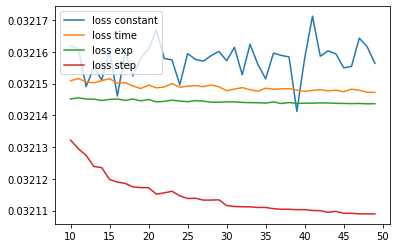

In [8]:
mynet = Network()

mynet.dense(16, relu, 10)
mynet.dense(32, relu)
mynet.dense(1, linear)

mydata = make_dataset(10000)
x = np.arange(10, 50)

optimizer = lambda lr, nabla, cache: sgd(lr, nabla, cache, alpha=0.9)

lr_schedulers = lambda lr, epoch: constant(lr, epoch)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss constant")

lr_schedulers = lambda lr, epoch: time_decay(lr, epoch, decay_rate=0.3)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss time")

lr_schedulers = lambda lr, epoch: exp_decay(lr, epoch, decay_rate=0.05)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss exp")

lr_schedulers = lambda lr, epoch: step_decay(lr, epoch, decay_rate=0.5, decay_step=15)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss step")


plt.legend()
plt.show()